In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

SR = 44100
blocksize = 88200
overlap = 44100

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 76ms/step - loss: 1.2447
Epoch 1/1
2/2 [==============================] - 0s 54ms/step - loss: 1.3319
	Bytes: 5621904
	Processing Time: 52.38104844093323


In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,...,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000,6058.000000
mean,0.274425,0.278048,0.196117,0.174222,0.157807,0.148653,0.138702,0.139089,0.129341,0.126932,...,-0.000091,0.000016,-0.000070,0.000057,-0.000020,0.000020,-0.000041,-0.000003,0.623968,24.517993
std,0.151244,0.153651,0.086790,0.075001,0.065857,0.060723,0.055634,0.057795,0.051140,0.050487,...,0.001409,0.001365,0.001341,0.001381,0.001393,0.001380,0.001329,0.001391,0.484428,14.509881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.071744,-0.071744,-0.071744,-0.019164,-0.019158,-0.060990,-0.060990,-0.060990,0.000000,0.000000
25%,0.152635,0.148390,0.136185,0.122215,0.114203,0.109709,0.102971,0.099801,0.096195,0.094515,...,-0.000131,-0.000038,-0.000118,-0.000044,-0.000108,-0.000052,-0.000098,-0.000055,0.000000,12.000000
50%,0.257627,0.270524,0.195047,0.173687,0.156311,0.147308,0.139855,0.138163,0.129147,0.126159,...,-0.000032,0.000028,-0.000026,0.000018,-0.000022,0.000011,-0.000015,0.000004,1.000000,24.000000
75%,0.376937,0.386941,0.251302,0.221092,0.197469,0.184328,0.171041,0.173471,0.158836,0.156608,...,0.000033,0.000125,0.000033,0.000107,0.000037,0.000092,0.000043,0.000081,1.000000,37.000000
max,0.782315,0.806713,0.617982,0.542252,0.532506,0.473240,0.473139,0.455183,0.469797,0.402358,...,0.012951,0.008564,0.016074,0.071744,0.071744,0.071744,0.071744,0.071744,1.000000,49.000000


In [12]:
a_data = df[df['l_target'] == 0]
i_data = df[df['l_target'] == 1]

# Animal Sounds

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(a_data, test_size=0.20, random_state=56)

In [14]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['h_target']

In [15]:
from sklearn.model_selection import GridSearchCV
params = {
          'n_estimators': range(5,25,1),
          'criterion': ('gini', 'entropy')
         }

rfc_a = RandomForestClassifier()

clf_a = GridSearchCV(rfc_a, params, cv=5)

clf_a.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(5, 25), 'criterion': ('gini', 'entropy')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
sorted(clf_a.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_criterion',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.6337719298245614
Confusion matrix, without normalization
[[15  1  0  0  0  0  1  0  0  1  0  0  1  1  0  0  0  0  0]
 [ 1  8  1  0  0  1  0  0  0  0  0  0  1  2  0  0  0  1  2]
 [ 1  0 11  0  0  0  0  2  0  0  0  0  1  1  2  0  0  0  1]
 [ 0  0  1 20  1  0  1  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  2  0 20  0  0  1  0  1  0  0  0  0  0  0  0  0  1]
 [ 2  2  0  2  1 14  0  1  1  0  0  0  0  2  0  0  0  2  0]
 [ 2  0  1  0  1  2 15  1  2  0  0  0  0  1  2  0  1  2  0]
 [ 0  0  0  2  1  0  1 14  0  0  1  0  0  0  0  1  1  0  1]
 [ 0  1  1  8  0  2  0  0 14  3  0  1  2  0  0  1  0  0  2]
 [ 1  2  1  1  0  0  0  0  2 18  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  1 29  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  1  0  0 14  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  1  0  0 21  1  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  1 11  1  0  1  0  0]
 [ 0  0  1  0  1  1  0  0  0  0  0  0  1  1 20  0  0  0  1]
 [ 1  3  0  2  0  0  2  1  1  2  0  0  1 

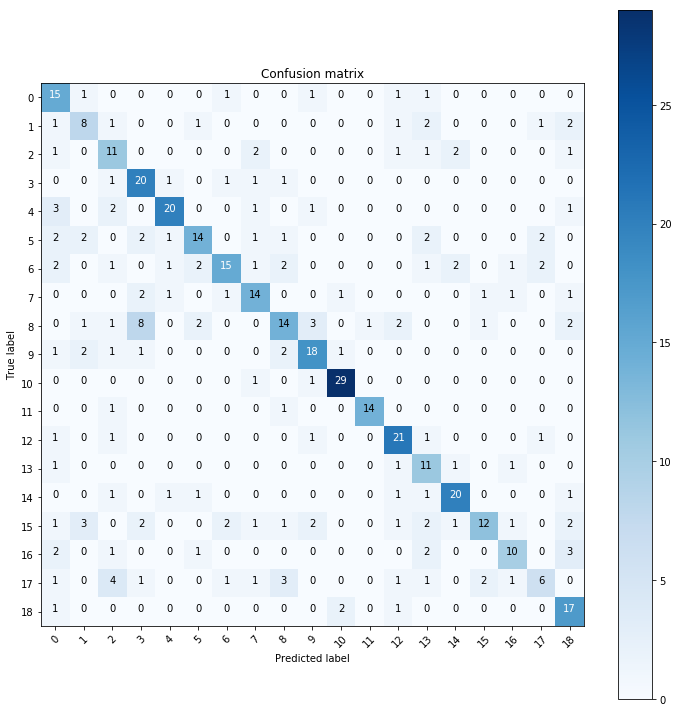

In [17]:
pred = clf_a.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,19))
plt.show()

# Interacting Materials

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(i_data, test_size=0.20, random_state=56)

In [19]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['h_target']

In [20]:
from sklearn.model_selection import GridSearchCV
params = {
          'n_estimators': range(5,25,1),
          'criterion': ('gini', 'entropy')
         }

rfc_i = RandomForestClassifier()

clf_i = GridSearchCV(rfc_i, params, cv=5)

clf_i.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(5, 25), 'criterion': ('gini', 'entropy')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
sorted(clf_i.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_criterion',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.6150793650793651
Confusion matrix, without normalization
[[18  6  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0
   0  0  0  0  0  0  0]
 [ 2 15  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  1  0
   0  1  1  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  3 12  0  0  0  0  0  1  1  0  4  1  0  2  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  1  2  0  0  0  0  0  0  0  0  3  0  0  0  0  4  0  0
   0  0  0  2  1  0  0]
 [ 0  0  2  1  0 20  0  0  1  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  2  0]
 [ 1  2  0  0  0  0 11  0  2  0  0  0  0  0  0  0  0  3  0  0  0  0  2  2
   0  0  1  0  0  1  3]
 [ 0  0  0  1  3  0  0 18  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0
   0  0  2  4  1  0  0]
 [ 0  0  0  1  0  0  2  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  2  0]
 [ 0  0  1  0  0  0  0  0  2 15  1  0  1  0  0  1  0  0  0 

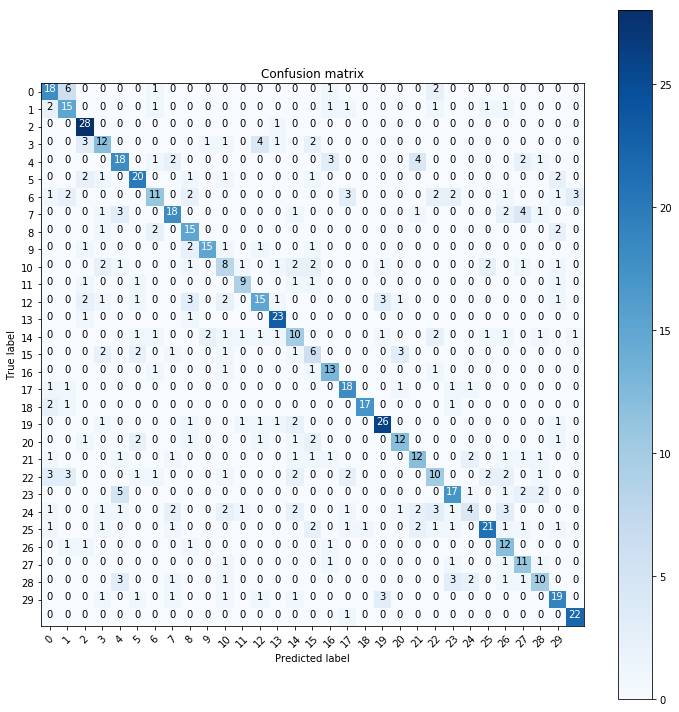

In [24]:
pred = clf_i.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,30))
plt.show()

# All Data

In [25]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 70ms/step - loss: 1.2513
Epoch 1/1
2/2 [==============================] - 0s 67ms/step - loss: 1.3342
	Bytes: 1397648
	Processing Time: 12.660957098007202


In [26]:
all_a_data = all_df[all_df['l_target'] == 0]
all_i_data = all_df[all_df['l_target'] == 1]

In [27]:
X = all_a_data.drop(['l_target', 'h_target'], axis=1)
y = all_a_data['h_target']

0.3102836879432624
Confusion matrix, without normalization
[[13  1  0  2  1  2  2  0  0  0  0  0  0  0  1  0  2  1  1]
 [ 2  8  0  4  0  1  1  0  1  1  1  0  1  2  0  1  0  0  0]
 [ 2  0 13  2  1  0  1  5  2  4  0  1  0  0  1  0  0  0  0]
 [ 5  0  0 12  1  4  1  1  0  1  0  1  2  1  0  0  0  0  2]
 [ 1  0  1  2 13  1  5  1  2  1  1  0  0  0  3  0  0  1  0]
 [ 1  1  0  2  0  4  2  1  4  3  3  2  2  4  0  2  1  0  0]
 [ 3  0  2  4  2  1  6  8  1  0  2  0  0  0  0  1  0  2  0]
 [ 0  2  1  0  0  0  1  3  1  3  0  5  1  0  5  2  2  1  3]
 [ 0  3  0  3  2  0  1  4 10  1  1  3  0  0  0  2  0  1  1]
 [ 0 10  0  0  1  3  0  3  0  4  2  1  3  0  1  2  0  2  0]
 [ 0  0  0  0  0  0  0  4  0  0 23  1  1  0  0  1  0  0  2]
 [ 0  0  0  0  2  0  3  0  1  2  4 14  0  0  1  1  0  2  2]
 [ 2  0  5  0  0  0  0  1  1  3  0  2 13  2  0  0  0  3  0]
 [ 0  1  0  0  3  1  0  0  0  0  0  0  2 15  0  0  0  0  1]
 [ 2  0  0  2  2  0  6  1  2  0  0  0  2  1 12  0  0  2  0]
 [ 1  1  1  2  1  2  0  0  0  1  0  0  4 

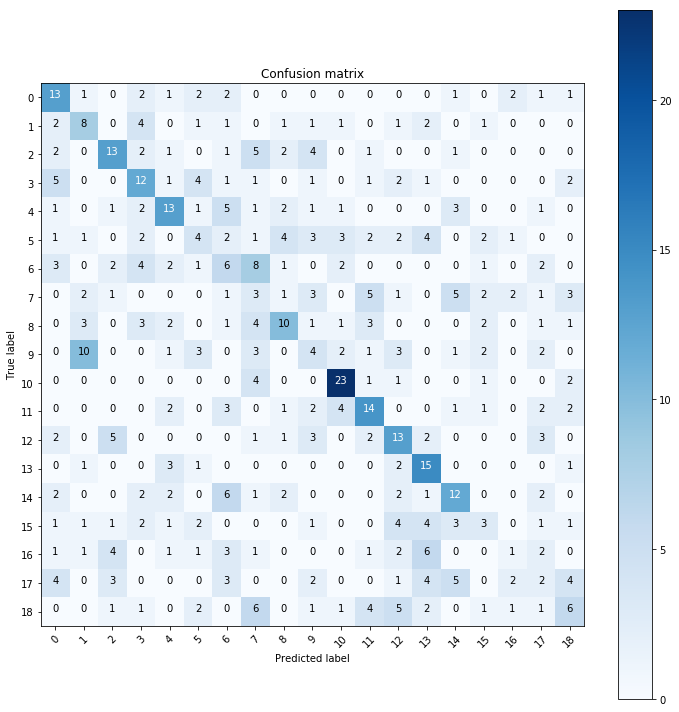

In [29]:
pred = clf_a.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,19))
plt.show()

In [30]:
X = all_i_data.drop(['l_target', 'h_target'], axis=1)
y = all_i_data['h_target']

0.28874734607218683
Confusion matrix, without normalization
[[ 4  3  0  0  0  0  2  0  0  0  0  0  0  0  0  0  1  8  0  0  0  9  2  0
   2  0  1  0  0  0  0]
 [ 5  2  0  0  1  0  2  0  1  0  0  0  0  0  0  0  9  8  0  0  0  0  1  2
   0  1  0  0  0  0  0]
 [ 0  0 14  0  0  2  0  0  3  1  0  0  4  7  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  1  6  0  2  0  0  5  0  1  0  5  0  1  5  0  0  1  2  0  0  0  0
   0  0  0  0  0  0  0]
 [ 1  1  0  0  5  3  2  0  0  0  0  0  0  0  0  0  4  7  0  0  0  1  0  2
   3  0  0  1  1  0  1]
 [ 0  0  1  1  0 19  0  1  0  1  2  0  0  0  0  1  0  0  0  0  2  0  0  0
   0  0  0  0  0  1  0]
 [ 5  0  0  0  0  3 12  1  1  1  0  0  0  0  0  0  1  4  0  0  0  0  1  0
   1  0  0  0  0  0  2]
 [ 0  0  1  1  4  0  0 19  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  2  0  3  0]
 [ 0  0  8  0  0  6  0  0  3  0  3  0  2  0  2  0  0  0  0  4  0  0  0  0
   0  0  0  0  0  1  0]
 [ 2  0  0  0  0  3  7  0  2  8  1  0  0  2  1  1  0  0  1

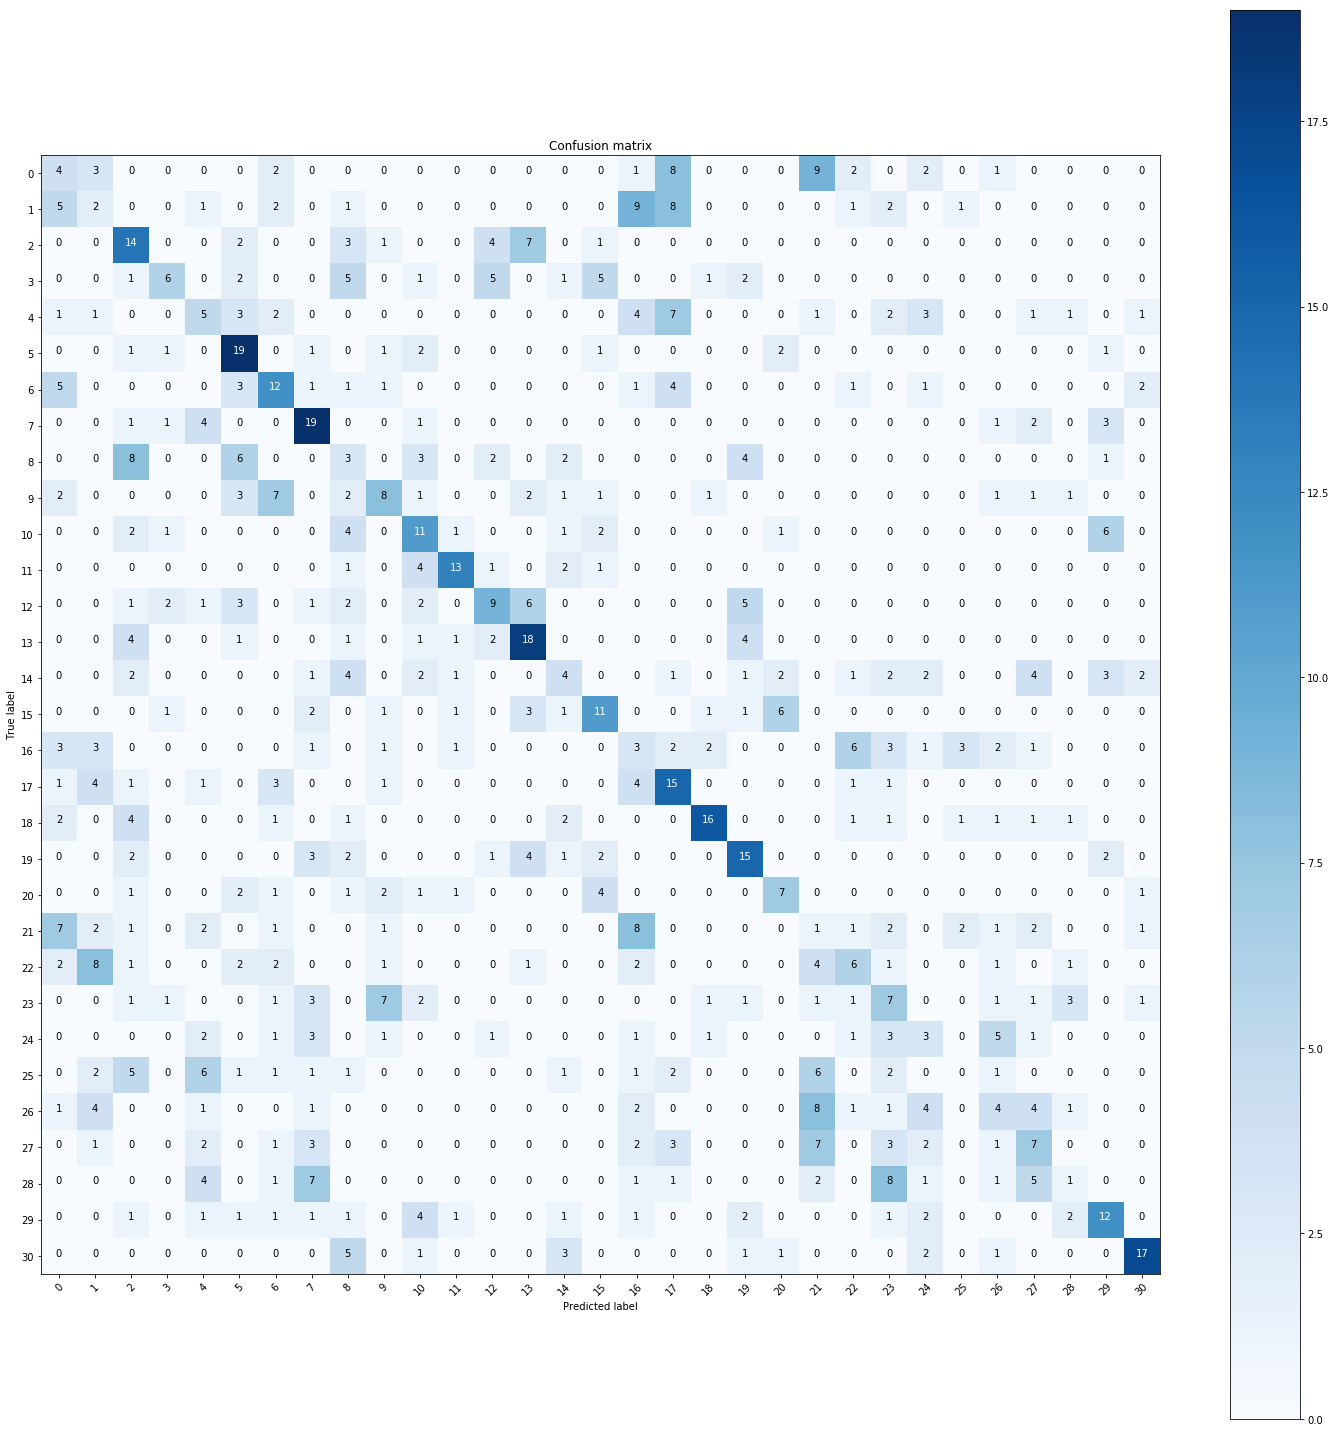

In [31]:
pred = clf_i.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, range(0,31))
plt.show()